In [4]:
# install optional libs (only if you plan to use them later) and imports
!pip install --quiet lightgbm catboost

import pandas as pd
import numpy as np
import io
import os
import joblib
from google.colab import files, drive

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

print("Libraries loaded.")


Libraries loaded.


In [5]:

uploaded = files.upload()  # pick Dataset
for fn in uploaded.keys():
    file_path = fn
    print("Uploaded file:", file_path)




Saving Dataset  (2).csv to Dataset  (2).csv
Uploaded file: Dataset  (2).csv


In [6]:
# robust loading - tries CSV then Excel
try:

    df = pd.read_csv(io.BytesIO(uploaded[file_path]), engine='python', on_bad_lines='skip')
    print("Loaded as CSV.")
except Exception as e_csv:
    print("CSV load failed:", str(e_csv))
    try:
        df = pd.read_excel(io.BytesIO(uploaded[file_path]))
        print("Loaded as Excel.")
    except Exception as e_xlsx:

        if os.path.exists(file_path) and file_path.lower().endswith(('.xls', '.xlsx')):
            df = pd.read_excel(file_path)
            print("Loaded Excel from Drive path.")
        else:
            raise RuntimeError("Failed to load file as CSV or Excel. Error CSV:", e_csv, "Error Excel:", e_xlsx)

print("Data shape:", df.shape)
display(df.head())


CSV load failed: 'utf-8' codec can't decode byte 0xe3 in position 14: invalid continuation byte
Loaded as Excel.
Data shape: (9551, 21)


,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [7]:
#  quick EDA and target detection
# Replace this if your target column name differs
target_col = "Aggregate rating"

if target_col not in df.columns:
    candidates = [c for c in df.columns if "rating" in c.lower() or "rate" in c.lower()]
    if candidates:
        target_col = candidates[0]
        print("Auto-detected target:", target_col)
    else:
        raise ValueError("Target column not found. Set target_col manually.")

print("Using target column:", target_col)
print("\nColumns list (first 40):")
print(df.columns.tolist()[:40])
print("\nMissing values (top 20):")
display(df.isnull().sum().sort_values(ascending=False).head(20))


Using target column: Aggregate rating

Columns list (first 40):
['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address', 'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Price range', 'Aggregate rating', 'Rating color', 'Rating text', 'Votes']

Missing values (top 20):


,0
Cuisines,9
Restaurant Name,0
Country Code,0
City,0
Restaurant ID,0
Address,0
Locality,0
Longitude,0
Locality Verbose,0
Latitude,0


In [8]:
# basic cleaning - drop ID-like columns and make string columns consistent
y = df[target_col]
X = df.drop(columns=[target_col])


id_like = [c for c in X.columns if any(k in c.lower() for k in ["id", "url", "link", "phone", "address"])]
print("Dropping identifier-like columns:", id_like)
X = X.drop(columns=id_like, errors='ignore')


for c in X.select_dtypes(include=['object', 'category', 'bool']).columns:
    X[c] = X[c].fillna("___missing___").astype(str)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features (first 30):", cat_features[:30])


Dropping identifier-like columns: ['Restaurant ID', 'Address']
Numeric features: ['Country Code', 'Longitude', 'Latitude', 'Average Cost for two', 'Price range', 'Votes']
Categorical features (first 30): ['Restaurant Name', 'City', 'Locality', 'Locality Verbose', 'Cuisines', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Rating color', 'Rating text']


In [10]:
#  define encoding strategy to avoid one-hot explosion
def frequency_encode(series):
    s = series.fillna("___missing___").astype(str)
    freqs = s.value_counts(normalize=True)
    return s.map(freqs).astype(float)

high_card_thresh = 20
low_card = [c for c in cat_features if X[c].nunique(dropna=False) <= high_card_thresh]
high_card = [c for c in cat_features if X[c].nunique(dropna=False) > high_card_thresh]

print("Low-cardinal categorical (one-hot):", low_card)
print("High-cardinal categorical (frequency-encode):", high_card[:30])

X_enc = X.copy()

for c in high_card:
    X_enc[c + "_freqenc"] = frequency_encode(X_enc[c])

X_enc = X_enc.drop(columns=high_card, errors='ignore')

numeric_features = X_enc.select_dtypes(include=[np.number]).columns.tolist()
onehot_features = [c for c in low_card if c in X_enc.columns]

print("Final numeric_features:", numeric_features)
print("Final onehot_features:", onehot_features)


Low-cardinal categorical (one-hot): ['Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Rating color', 'Rating text']
High-cardinal categorical (frequency-encode): ['Restaurant Name', 'City', 'Locality', 'Locality Verbose', 'Cuisines']
Final numeric_features: ['Country Code', 'Longitude', 'Latitude', 'Average Cost for two', 'Price range', 'Votes', 'Restaurant Name_freqenc', 'City_freqenc', 'Locality_freqenc', 'Locality Verbose_freqenc', 'Cuisines_freqenc']
Final onehot_features: ['Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Rating color', 'Rating text']


In [12]:
# create preprocessing pipeline and train/test split
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, onehot_features)
], remainder='drop')

# Split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (7640, 18) Test shape: (1911, 18)


In [13]:
# train three baseline models
models = {
    "LinearRegression": Pipeline([('preproc', preprocessor), ('reg', LinearRegression())]),
    "DecisionTree": Pipeline([('preproc', preprocessor), ('reg', DecisionTreeRegressor(random_state=42, max_depth=8))]),
    "RandomForest": Pipeline([('preproc', preprocessor), ('reg', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1, max_depth=12))])
}

results = {}
for name, pipe in models.items():
    print("Training:", name)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    results[name] = {"pipe": pipe, "mse": mse, "rmse": rmse, "r2": r2, "preds": preds}
    print(f"  {name} -> RMSE: {rmse:.4f}, R2: {r2:.4f}")


Training: LinearRegression
  LinearRegression -> RMSE: 0.1761, R2: 0.9864
Training: DecisionTree
  DecisionTree -> RMSE: 0.1758, R2: 0.9864
Training: RandomForest
  RandomForest -> RMSE: 0.1680, R2: 0.9876


In [14]:
#  evaluate models and pick best by R2
res_df = pd.DataFrame([{"model":k, "mse":v["mse"], "rmse":v["rmse"], "r2":v["r2"]} for k,v in results.items()]).set_index("model")
display(res_df)
best_name = res_df['r2'].idxmax()
print("Best model:", best_name)
best_pipe = results[best_name]['pipe']
y_pred = results[best_name]['preds']


,mse,rmse,r2
model,,,
LinearRegression,0.030994,0.176052,0.986383
DecisionTree,0.030921,0.175845,0.986415
RandomForest,0.028232,0.168024,0.987596


Best model: RandomForest


from matplotlib import pyplot as plt
res_df['mse'].plot(kind='hist', bins=20, title='mse')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df['rmse'].plot(kind='hist', bins=20, title='rmse')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df['r2'].plot(kind='hist', bins=20, title='r2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df.plot(kind='scatter', x='mse', y='rmse', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_df.plot(kind='scatter', x='rmse', y='r2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['r2']
  ys = series['mse']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = res_df.sort_values('r2', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('r2')
_ = plt.ylabel('mse')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['r2']
  ys = series['rmse']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = res_df.sort_values('r2', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('r2')
_ = plt.ylabel('rmse')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['r2']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'r2'}, axis=1)
              .sort_values('r2', ascending=True))
  xs = counted['r2']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = res_df.sort_values('r2', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('r2')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
res_df['mse'].plot(kind='line', figsize=(8, 4), title='mse')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_df['rmse'].plot(kind='line', figsize=(8, 4), title='rmse')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_df['r2'].plot(kind='line', figsize=(8, 4), title='r2')
plt.gca().spines[['top', 'right']].set_visible(False)

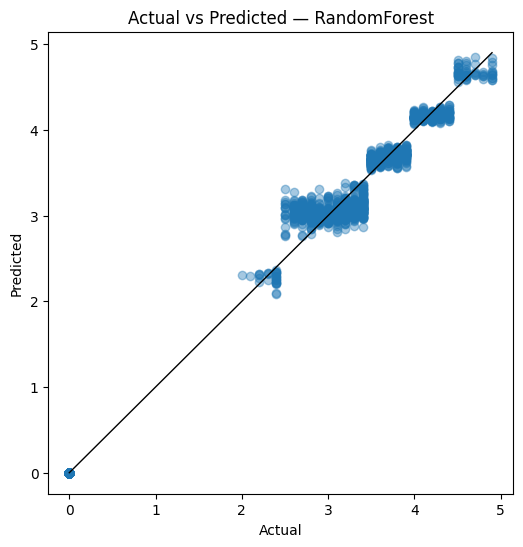

,actual,predicted
0,2.1,2.294
1,4.1,4.119
2,3.2,2.950
3,4.4,4.121
4,3.5,3.532
5,0.0,0.000
6,3.2,3.049
7,0.0,0.000
8,3.6,3.646
9,4.0,4.077


In [15]:
# actual vs predicted plot and sample outputs
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linewidth=1, color='k')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted — {best_name}")
plt.show()

# Sample table
out = pd.DataFrame({"actual": y_test.reset_index(drop=True), "predicted": np.round(y_pred,3)})
display(out.head(20))


Number of transformed features: 42


,0
Rating text_Not rated,0.343130
Votes,0.308571
Rating color_White,0.252891
Rating text_Average,0.029601
Rating color_Orange,0.022345
Rating text_Poor,0.012345
Rating color_Red,0.010023
Rating text_Good,0.006695
Rating color_Yellow,0.006428
Longitude,0.001137


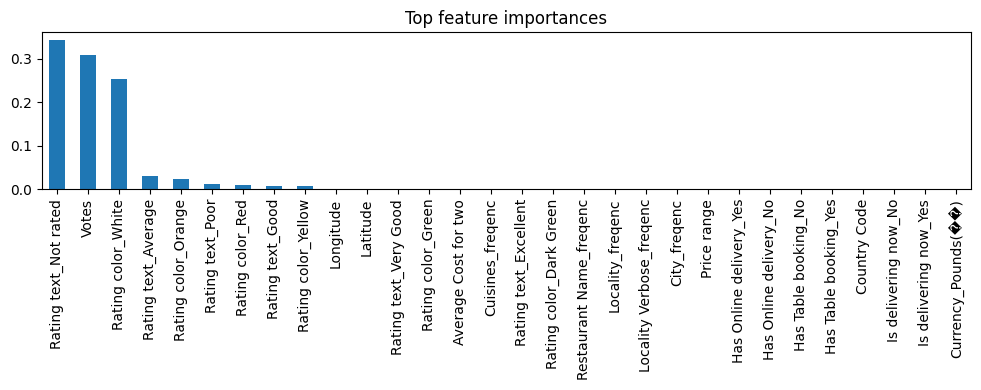

In [16]:
#  build transformed feature names and show importances or coefficients

num_names = numeric_features.copy()

ohe_names = []
if onehot_features:
    ohe = best_pipe.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
    ohe_names = list(ohe.get_feature_names_out(onehot_features))

feature_names = num_names + ohe_names
print("Number of transformed features:", len(feature_names))

reg = best_pipe.named_steps['reg']
if hasattr(reg, "feature_importances_"):
    fi = pd.Series(reg.feature_importances_, index=feature_names).sort_values(ascending=False).head(30)
    display(fi)
    plt.figure(figsize=(10,4)); fi.plot(kind='bar'); plt.title("Top feature importances"); plt.tight_layout(); plt.show()
else:
    coefs = pd.Series(reg.coef_, index=feature_names).sort_values(key=abs, ascending=False).head(30)
    display(coefs)
    plt.figure(figsize=(10,4)); coefs.plot(kind='bar'); plt.title("Top linear coefficients"); plt.tight_layout(); plt.show()


In [17]:
#  save best pipeline and predictions; then download
save_model_path = "/content/best_rating_model.pkl"
joblib.dump(best_pipe, save_model_path)
print("Saved model to", save_model_path)

# Save predictions
preds_df = pd.DataFrame({"actual": y_test.reset_index(drop=True), "predicted": np.round(y_pred,3)})
preds_csv = "/content/rating_predictions.csv"
preds_df.to_csv(preds_csv, index=False)
print("Saved predictions to", preds_csv)

# Download (will prompt browser download)
files.download(save_model_path)
files.download(preds_csv)


Saved model to /content/best_rating_model.pkl
Saved predictions to /content/rating_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# a quick LightGBM run (preprocess X -> arrays first)
import lightgbm as lgb

# Transform using our pipeline preprocessor only (not the final regressor)
X_tr = best_pipe.named_steps['preproc'].transform(X_train)
X_te = best_pipe.named_steps['preproc'].transform(X_test)

lgb_train = lgb.Dataset(X_tr, label=y_train)
params = {"objective": "regression", "metric": "rmse", "verbosity": -1}
bst = lgb.train(params, lgb_train, num_boost_round=200)
preds_lgb = bst.predict(X_te)
print("LightGBM RMSE:", np.sqrt(mean_squared_error(y_test, preds_lgb)))


LightGBM RMSE: 0.17085601125617716
